Import Library

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import os
from geopy.geocoders import Nominatim
import pickle

In [2]:
import gym
import time
import math
import random
import itertools
import numpy as np 
import tensorflow as tf 
from statistics import mean
from collections import deque, namedtuple
import tensorflow.keras.layers as kl
import tensorflow.keras.models as km
import tensorflow.keras.optimizers as ko
import tensorflow.keras.losses as kls
from tensorflow.keras.callbacks import TensorBoard

In [3]:
from matplotlib import cm
import matplotlib.colors as mcolors

1. Mengambil Data Jaringan Jalan dari OSM & SPKLU ( Dataset)

In [ ]:
# STEP 1: MENGAMBIL DATA JALAN dari OSM

# Daftar kota yang akan diproses
cities = ["Surabaya, Indonesia", "Malang, Indonesia", "Kediri, Indonesia", "Sidoarjo, Indonesia", "Gresik, Indonesia"]
data_dir = "../data"  # lokasi penyimpanan file .pkl

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    filepath = f"{data_dir}/road_graph_{safe_name}.pkl"
    
    if os.path.exists(filepath):
        print(f"✅ Data jalan {city_name} sudah tersedia.")
    else:
        print(f"📥 Mengambil data jalan dari OSM: {city_name}...")
        
        # Ambil jaringan jalan yang bisa dilalui mobil
        G = ox.graph_from_place(city_name, network_type="drive", simplify=True)
        
        # Simpan ke file .pkl
        nx.write_gpickle(G, filepath)
        print(f"💾 Data jalan {city_name} disimpan sebagai {filepath}")

✅ Data jalan Surabaya, Indonesia sudah tersedia.
✅ Data jalan Malang, Indonesia sudah tersedia.
✅ Data jalan Kediri, Indonesia sudah tersedia.
✅ Data jalan Sidoarjo, Indonesia sudah tersedia.
✅ Data jalan Gresik, Indonesia sudah tersedia.


In [6]:
# STEP 2: MEMUAT DATA SPKLU dari CSV

spklu_path = f"{data_dir}/spklu_dataset.csv"
spklu_df = pd.read_csv(spklu_path)

print("📊 Contoh data SPKLU:")
print(f"📄 Jumlah SPKLU dalam dataset: {len(spklu_df)}")

display(spklu_df.head())

📊 Contoh data SPKLU:
📄 Jumlah SPKLU dalam dataset: 10


,Nama SPKLU,Alamat,Latitude,Longitude,Jenis Konektor & Daya
0,SPKLU Gedung Pemkot Surabaya,"PPRX+R52 Ketabang, Surabaya, East Java",-7.257996,112.747887,AC TYPE 2 - 22KW
1,SPKLU Balai Kota Surabaya,"PPRX+R52 Ketabang, Surabaya, East Java",-7.257996,112.747887,AC TYPE 2 - 22KW
2,SPKLU WTC Surabaya Mall,"PPPX+X7C Embong Kaliasin, Surabaya, East Java",-7.262561,112.748145,"AC TYPE - 22KW, CCS 2 - 60KW DC, CHAdeMO - 60K..."
3,SPKLU PLN UID Jawa Timur,"PPMV+P77 Embong Kaliasin, Surabaya, East Java",-7.265702,112.743163,"AC TYPE - 7KW, CCS 2 - 100KW DC"
4,SPKLU Emergency Mobile,"PPMV+J63 Embong Kaliasin, Surabaya, East Java",-7.265988,112.743054,"AC TYPE - 22KW, CCS 2 - 30KW DC"


In [7]:
# STEP 3: Tambahkan Bobot Jarak dan Energi ke Graf Jalan

def calculate_energy(length_km, inclination):
    base_consumption = 0.2  # konsumsi energi rata-rata mobil listrik di jalan datar
    elevation_factor = 0.05  # penambahan konsumsi energi karena tanjakan
    return base_consumption * length_km + elevation_factor * (length_km * inclination)

print("\n⚙️ Mulai proses pemberian bobot ke graf jalan...")

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    graph_path = f"{data_dir}/road_graph_{safe_name}.pkl"
    
    if not os.path.exists(graph_path):
        print(f"❌ Tidak ada graf jalan untuk {city_name}. Lewati.")
        continue

    try:
        # Menggunakan pickle untuk membaca file graf jalan
        with open(graph_path, 'rb') as f:
            G = pickle.load(f)
    except Exception as e:
        print(f"❌ Error saat memuat graf jalan {city_name}: {e}")
        continue

    # Tambahkan bobot pada setiap edge (jalan)
    for u, v, data in G.edges(data=True):
        length_km = data.get("length", 1) / 1000  # Pastikan nilai default adalah 1 jika tidak ada data 'length'
        inclination = data.get("grade", 0)

        # Menangani kasus jika tidak ada data untuk 'length' atau 'grade'
        if length_km is None:
            length_km = 1  # Set default jika tidak ada panjang
        if inclination is None:
            inclination = 0  # Set default jika tidak ada kemiringan

        data["distance"] = length_km
        data["energy"] = calculate_energy(length_km, inclination)

    weighted_path = f"{data_dir}/road_graph_weighted_{safe_name}.pkl"
    try:
        # Menggunakan pickle untuk menyimpan file graf jalan yang sudah diberi bobot
        with open(weighted_path, 'wb') as f:
            pickle.dump(G, f)
        print(f"💾 Bobot distance & energy disimpan: {weighted_path}")
    except Exception as e:
        print(f"❌ Gagal menyimpan graf dengan bobot untuk {city_name}: {e}")

print("✅ Semua graf diperbarui dengan bobot konsumsi energi.")



⚙️ Mulai proses pemberian bobot ke graf jalan...
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_surabaya.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_malang.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_kediri.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_sidoarjo.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_gresik.pkl
✅ Semua graf diperbarui dengan bobot konsumsi energi.


In [8]:
# STEP 4: Menambahkan SPKLU ke Graf Jalan

print("\n📌 Menambahkan SPKLU ke dalam graf jalan...\n")

spklu_nodes_per_city = {}  

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    graph_path = f"{data_dir}/road_graph_weighted_{safe_name}.pkl"

    if not os.path.exists(graph_path):
        print(f"⚠️ Lewat: Data graf {city_name} belum ada.")
        continue

  # Membaca graf menggunakan pickle
    try:
        with open(graph_path, 'rb') as f:
            G = pickle.load(f)
    except Exception as e:
        print(f"❌ Gagal memuat graf untuk {city_name}: {e}")
        continue


    city_name_only = city_name.split(",")[0]
    city_spklu = spklu_df[spklu_df["Alamat"].str.contains(city_name_only, case=False, na=False)]

    spklu_nodes = {}
    for _, row in city_spklu.iterrows():
        try:
            node_id = ox.nearest_nodes(G, row["Longitude"], row["Latitude"])

            raw_konektor = row["Jenis Konektor & Daya"]
            konektor_list = [
                k.strip().split("-")[0].strip().replace(" ", "").upper()
                for k in raw_konektor.split(",")
            ]

            spklu_nodes[node_id] = {
                "coords": (row["Latitude"], row["Longitude"]),
                "available_connectors": konektor_list
            }
            
            G.nodes[node_id]["is_spklu"] = True

        except Exception as e:
            print(f"⚠️ Error mencari node terdekat untuk SPKLU di {city_name}: {e}")

    spklu_nodes_per_city[city_name_only] = spklu_nodes
    print(f"✅ {len(spklu_nodes)} SPKLU berhasil dimapping ke graf {city_name_only}.")
    
    # Simpan ulang graf dengan SPKLU info 
    try:
        with open(graph_path, 'wb') as f:
            pickle.dump(G, f)
        print(f"💾 Graf dengan SPKLU disimpan kembali untuk {city_name_only}.")
    except Exception as e:
        print(f"❌ Gagal menyimpan graf dengan SPKLU untuk {city_name_only}: {e}")


📌 Menambahkan SPKLU ke dalam graf jalan...

✅ 9 SPKLU berhasil dimapping ke graf Surabaya.
💾 Graf dengan SPKLU disimpan kembali untuk Surabaya.
✅ 0 SPKLU berhasil dimapping ke graf Malang.
💾 Graf dengan SPKLU disimpan kembali untuk Malang.
✅ 0 SPKLU berhasil dimapping ke graf Kediri.
💾 Graf dengan SPKLU disimpan kembali untuk Kediri.
✅ 0 SPKLU berhasil dimapping ke graf Sidoarjo.
💾 Graf dengan SPKLU disimpan kembali untuk Sidoarjo.
✅ 0 SPKLU berhasil dimapping ke graf Gresik.
💾 Graf dengan SPKLU disimpan kembali untuk Gresik.


In [9]:
# Pengecekan hasil mapping SPKLU

# Membaca graf yang sudah disimpan
graph_path = "../data/road_graph_weighted_surabaya.pkl"
try:
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)
    print(f"✅ Graf jalan Surabaya berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat graf jalan Surabaya: {e}")
    G = None

if G is not None:
    spklu_nodes = spklu_nodes_per_city["Surabaya"]

    # Pengecekan 3 node SPKLU pertama
    print("📍 Pengecekan Node SPKLU:")
    for node_id in list(spklu_nodes.keys())[:3]:
        if node_id in G.nodes:
            print(f"✅ Node SPKLU {node_id} ditemukan di graf jalan.")
            print(f"   📍 Koordinat: {spklu_nodes[node_id]['coords']}")
            print(f"   🔌 Tersedia konektor: {', '.join(spklu_nodes[node_id]['available_connectors'])}\n")
        else:
            print(f"❌ Node SPKLU {node_id} TIDAK ditemukan di graf jalan.\n")

    # Pengecekan 3 edge pertama dan bobotnya (distance & energy)
    print("📊 Pengecekan 3 Edge Pertama dalam Graf Jalan:")
    for u, v, data in list(G.edges(data=True))[:3]:
        print(f"✅ Edge {u} → {v}")
        print(f"   📏 Jarak: {data.get('distance')} km")
        print(f"   ⚡ Energi: {data.get('energy')} kWh\n")

    # Menampilkan jumlah node dan edge
    print("🔢 Statistik Graf Jalan:")
    print(f"   Total Jumlah Node: {len(G.nodes)}")
    print(f"   Total Jumlah Edge: {len(G.edges)}\n")

    # Mengecek jumlah SPKLU node dalam graf
    print("🔌 Pengecekan Jumlah Node SPKLU dalam Graf:")
    spklu_nodes_list = [n for n, attr in G.nodes(data=True) if attr.get("is_spklu") == True]
    print(f"   Total Jumlah Node SPKLU: {len(spklu_nodes_list)}\n")

    # Untuk informasi lebih lanjut, tampilkan SPKLU node pertama jika ada
    if len(spklu_nodes_list) > 0:
        first_spklu = spklu_nodes_list[0]
        print(f"📍 SPKLU pertama yang ditemukan: Node {first_spklu}")
        print(f"   Koordinat: {G.nodes[first_spklu].get('y')}, {G.nodes[first_spklu].get('x')}")
    else:
        print("❌ Tidak ada node SPKLU yang ditemukan dalam graf jalan.\n")


✅ Graf jalan Surabaya berhasil dimuat.
📍 Pengecekan Node SPKLU:
✅ Node SPKLU 1283196012 ditemukan di graf jalan.
   📍 Koordinat: (-7.257996, 112.747887)
   🔌 Tersedia konektor: ACTYPE2

✅ Node SPKLU 3522371774 ditemukan di graf jalan.
   📍 Koordinat: (-7.262561, 112.748145)
   🔌 Tersedia konektor: ACTYPE, CCS2, CHADEMO

✅ Node SPKLU 4222366095 ditemukan di graf jalan.
   📍 Koordinat: (-7.265702, 112.743163)
   🔌 Tersedia konektor: ACTYPE, CCS2

📊 Pengecekan 3 Edge Pertama dalam Graf Jalan:
✅ Edge 257690921 → 5579670363
   📏 Jarak: 0.10588367613445859 km
   ⚡ Energi: 0.02117673522689172 kWh

✅ Edge 257690940 → 1682372817
   📏 Jarak: 0.0793684357411614 km
   ⚡ Energi: 0.01587368714823228 kWh

✅ Edge 257690940 → 1682373086
   📏 Jarak: 0.09905907251489833 km
   ⚡ Energi: 0.01981181450297967 kWh

🔢 Statistik Graf Jalan:
   Total Jumlah Node: 36848
   Total Jumlah Edge: 89815

🔌 Pengecekan Jumlah Node SPKLU dalam Graf:
   Total Jumlah Node SPKLU: 9

📍 SPKLU pertama yang ditemukan: Node 33562

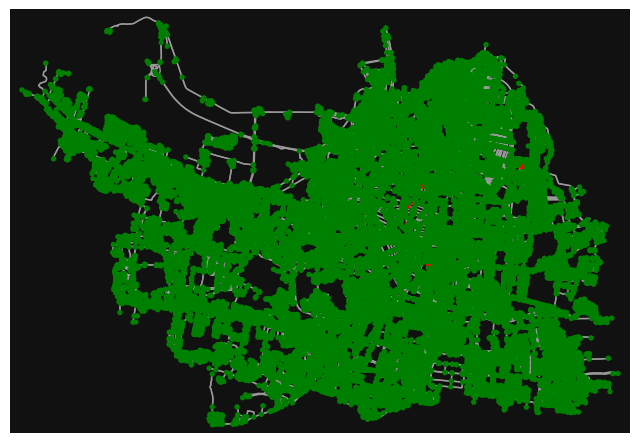

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
# Melihat SPKLU sudah masuk ke graf
ox.plot_graph(G, node_color=["red" if n in spklu_nodes else "green" for n in G.nodes])

2. Input dan Persiapan Data

Fungsi yang sudah kamu kerjakan:
Ambil input lokasi awal & tujuan dari user

Konversi lokasi ke koordinat menggunakan geopy

Cari node graf jalan terdekat dari koordinat dengan find_nearest_node()

Ambil input info kendaraan (baterai dan konektor)

Hitung energi yang tersedia (dalam kWh)

In [ ]:
import networkx as nx
import pickle
from geopy.geocoders import Nominatim
import math
from math import radians, sin, cos, sqrt, atan2

# 📂 Load graph dari file Surabaya
with open("../data/road_graph_weighted_surabaya.pkl", "rb") as f:
    G = pickle.load(f)

print("✅ Graf jalan Surabaya berhasil dimuat.")

# Fungsi untuk menghitung jarak antara dua koordinat menggunakan Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # radius bumi dalam km
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Fungsi untuk mencari node terdekat
def find_nearest_node(G, coord):
    min_dist = float('inf')
    nearest_node = None
    for node, data in G.nodes(data=True):
        if 'x' in data and 'y' in data:
            node_coord = (data['y'], data['x'])  # Koordinat x dan y node
            dist = haversine(coord[1], coord[0], node_coord[1], node_coord[0])
            if dist < min_dist:
                min_dist = dist
                nearest_node = node
    return nearest_node

# Fungsi untuk memeriksa apakah konektor tersedia pada node SPKLU
def is_connector_available(node_id, connector_type):
    if node_id in G.nodes:
        available_connectors = G.nodes[node_id].get('available_connectors', [])
        print(f"Node {node_id} has connectors: {available_connectors}")  
        if connector_type in available_connectors:
            return True
    return False


# 🔢 Input user
geolocator = Nominatim(user_agent="ev_route_finder")
start_address = input("Masukkan lokasi awal: ")
end_address = input("Masukkan lokasi tujuan: ")

start_location = geolocator.geocode(start_address)
end_location = geolocator.geocode(end_address)

if not start_location or not end_location:
    print("❌ Lokasi tidak ditemukan. Pastikan alamat dimasukkan dengan benar.")
    exit()

start_coords = (start_location.latitude, start_location.longitude)
end_coords = (end_location.latitude, end_location.longitude)

# Temukan node terdekat di graf berdasarkan koordinat
start_node = find_nearest_node(G, start_coords)
end_node = find_nearest_node(G, end_coords)

if not start_node or not end_node:
    print("❌ Node terdekat tidak ditemukan. Pastikan alamat berada dalam jangkauan graf.")
    exit()

# Output informasi input
print("\n--- Input User ---")
print(f"Lokasi awal: {start_address} → Koordinat: {start_coords}")
print(f"Lokasi tujuan: {end_address} → Koordinat: {end_coords}")
print(f"Node awal terdekat: {start_node}")
print(f"Node tujuan terdekat: {end_node}")

# Pilihan kapasitas baterai
battery_options = {
    1: {"model": "Wuling Air EV Standard Range", "capacity": 17.3, "range": 200},
    2: {"model": "Wuling Air EV Long Range", "capacity": 31.9, "range": 300},
    3: {"model": "Wuling BinguoEV Premium Range", "capacity": 37.9, "range": 410},
    4: {"model": "Wuling BinguoEV Long Range", "capacity": 31.9, "range": 333},
    5: {"model": "Wuling Cloud EV", "capacity": 50.6, "range": 460}
}

print("\nPilih kapasitas baterai mobil:")
for key, value in battery_options.items():
    print(f"{key}. {value['model']} (Jarak Tempuh: {value['range']} km, Kapasitas: {value['capacity']} kWh)")

try:
    battery_choice = int(input("Masukkan pilihan kapasitas baterai (1-5): "))
    selected_battery = battery_options.get(battery_choice)

    if not selected_battery:
        raise ValueError("❌ Pilihan tidak valid.")
except ValueError as e:
    print(e)
    exit()

# Input kapasitas baterai dan level baterai saat ini
try:
    battery_capacity = selected_battery['capacity']
    current_battery_percent = float(input("Masukkan persentase baterai saat ini (0-100): "))

    if not (0 <= current_battery_percent <= 100):
        raise ValueError("❌ Persentase baterai harus antara 0 dan 100.")
    
    connector_type = input("Masukkan jenis konektor (CCS2, AC Type 2, GBT, CHAdeMO): ")

    if connector_type not in ['CCS2', 'AC Type 2', 'GBT', 'CHAdeMO']:
        raise ValueError("❌ Jenis konektor tidak valid. Pilih antara: CCS2, AC Type 2, GBT, CHAdeMO.")
    
    current_energy = (current_battery_percent / 100.0) * battery_capacity
except ValueError as e:
    print(e)
    exit()

# Menghitung jarak perjalanan
distance = haversine(start_coords[1], start_coords[0], end_coords[1], end_coords[0])
print(f"Jarak antara lokasi awal dan tujuan: {distance:.2f} km")

# Konsumsi energi kendaraan (kWh per km) - asumsikan 0.2 kWh/km untuk kendaraan listrik
energy_consumption_per_km = 0.2  # dalam kWh/km
required_energy = energy_consumption_per_km * distance

print(f"Jumlah energi yang dibutuhkan untuk perjalanan: {required_energy:.2f} kWh")

# Cek apakah energi yang tersedia cukup untuk perjalanan
if current_energy < required_energy:
    print("❌ Energi tidak cukup untuk perjalanan. Mengisi ulang baterai diperlukan.")
    
    # Tentukan jumlah pengisian yang dibutuhkan
    energy_needed = required_energy - current_energy
    print(f"Jumlah energi yang dibutuhkan untuk pengisian: {energy_needed:.2f} kWh")
    
    # Cari SPKLU terdekat (logika pencarian SPKLU akan lebih detail)
    spklu_location = find_nearest_node(G, start_coords)  # Cari SPKLU terdekat dari lokasi awal
    print(f"SPKLU terdekat ditemukan di node: {spklu_location}")

    # Periksa apakah konektor yang diminta tersedia di SPKLU terdekat
    if is_connector_available(spklu_location, connector_type):
        print(f"✅ Konektor {connector_type} tersedia di SPKLU terdekat.")
    else:
        print(f"❌ Konektor {connector_type} tidak tersedia di SPKLU terdekat.")

    # Jika energi masih tidak cukup, cari SPKLU terdekat dari tujuan
    spklu_location = find_nearest_node(G, end_coords)  # Cari SPKLU terdekat dari lokasi tujuan
    print(f"SPKLU terdekat ditemukan di node: {spklu_location}")

    # Periksa apakah konektor yang diminta tersedia di SPKLU terdekat
    if is_connector_available(spklu_location, connector_type):
        print(f"✅ Konektor {connector_type} tersedia di SPKLU terdekat.")
    else:
        print(f"❌ Konektor {connector_type} tidak tersedia di SPKLU terdekat.")
else:
    print("✅ Energi cukup untuk perjalanan.")


✅ Graf jalan Surabaya berhasil dimuat.

--- Input User ---
Lokasi awal: universitas ciputra surabaya → Koordinat: (-7.2865722, 112.6320953)
Lokasi tujuan: tunjungan mall → Koordinat: (-7.2623869, 112.739006)
Node awal terdekat: 3224672310
Node tujuan terdekat: 5579915086

Pilih kapasitas baterai mobil:
1. Wuling Air EV Standard Range (Jarak Tempuh: 200 km, Kapasitas: 17.3 kWh)
2. Wuling Air EV Long Range (Jarak Tempuh: 300 km, Kapasitas: 31.9 kWh)
3. Wuling BinguoEV Premium Range (Jarak Tempuh: 410 km, Kapasitas: 37.9 kWh)
4. Wuling BinguoEV Long Range (Jarak Tempuh: 333 km, Kapasitas: 31.9 kWh)
5. Wuling Cloud EV (Jarak Tempuh: 460 km, Kapasitas: 50.6 kWh)
Jarak antara lokasi awal dan tujuan: 12.10 km
Jumlah energi yang dibutuhkan untuk perjalanan: 2.42 kWh
✅ Energi cukup untuk perjalanan.


In [122]:
# Debugging: Menampilkan nilai-nilai untuk memeriksa state
print("\n--- Debugging State ---")
print(f"Current Energy: {current_energy:.2f} kWh")
print(f"Distance to Target: {distance:.2f} km")

# Cek apakah connector_one_hot sudah dihitung dengan benar
connector_one_hot = [1 if is_connector_available(start_node, connector_type) else 0,
                     1 if is_connector_available(end_node, connector_type) else 0]

print(f"Connector One Hot: {connector_one_hot}")

# Membuat state
state = np.array([current_energy, distance, *connector_one_hot])

# Menampilkan state
print(f"State yang akan dikirim ke DQN: {state}")



--- Debugging State ---
Current Energy: 3.19 kWh
Distance to Target: 12.10 km
Connector One Hot: [0, 0]
State yang akan dikirim ke DQN: [ 3.19       12.09500648  0.          0.        ]


In [ ]:
# import networkx as nx
# import pickle
# from geopy.geocoders import Nominatim

# # 📂 Load graph dari file Surabaya
# with open("../data/road_graph_weighted_surabaya.pkl", "rb") as f:
#     G = pickle.load(f)

# print("✅ Graf jalan Surabaya berhasil dimuat.")

# # Fungsi untuk menemukan node terdekat dari koordinat (tanpa rekursi)
# def find_nearest_node(G, coord):
#     min_dist = float('inf')
#     nearest_node = None
#     for node, data in G.nodes(data=True):
#         if 'x' in data and 'y' in data:
#             node_coord = (data['y'], data['x'])  # Periksa apakah koordinat x dan y ada
#             dist = haversine(coord[1], coord[0], node_coord[1], node_coord[0])
#             if dist < min_dist:
#                 min_dist = dist
#                 nearest_node = node
#     return nearest_node

# # 🔢 Input user
# geolocator = Nominatim(user_agent="ev_route_finder")
# start_address = input("Masukkan lokasi awal: ")
# end_address = input("Masukkan lokasi tujuan: ")

# start_location = geolocator.geocode(start_address)
# end_location = geolocator.geocode(end_address)

# if not start_location or not end_location:
#     print("❌ Lokasi tidak ditemukan. Pastikan alamat dimasukkan dengan benar.")
#     exit()

# start_coords = (start_location.latitude, start_location.longitude)
# end_coords = (end_location.latitude, end_location.longitude)

# # Temukan node terdekat di graf berdasarkan koordinat
# start_node = find_nearest_node(G, start_coords)
# end_node = find_nearest_node(G, end_coords)

# if not start_node or not end_node:
#     print("❌ Node terdekat tidak ditemukan. Pastikan alamat berada dalam jangkauan graf.")
#     exit()

# # Pilihan kapasitas baterai
# battery_options = {
#     1: {"model": "Wuling Air EV Standard Range", "capacity": 17.3, "range": 200},
#     2: {"model": "Wuling Air EV Long Range", "capacity": 31.9, "range": 300},
#     3: {"model": "Wuling BinguoEV Premium Range", "capacity": 37.9, "range": 410},
#     4: {"model": "Wuling BinguoEV Long Range", "capacity": 31.9, "range": 333},
#     5: {"model": "Wuling Cloud EV", "capacity": 50.6, "range": 460}
# }

# print("\nPilih kapasitas baterai mobil:")
# for key, value in battery_options.items():
#     print(f"{key}. {value['model']} (Jarak Tempuh: {value['range']} km, Kapasitas: {value['capacity']} kWh)")

# try:
#     battery_choice = int(input("Masukkan pilihan kapasitas baterai (1-5): "))
#     selected_battery = battery_options.get(battery_choice)

#     if not selected_battery:
#         raise ValueError("❌ Pilihan tidak valid.")
# except ValueError as e:
#     print(e)
#     exit()

# # Input kapasitas baterai dan level baterai saat ini
# try:
#     battery_capacity = selected_battery['capacity']
#     current_battery_percent = float(input("Masukkan persentase baterai saat ini (0-100): "))

#     if not (0 <= current_battery_percent <= 100):
#         raise ValueError("❌ Persentase baterai harus antara 0 dan 100.")
    
#     connector_type = input("Masukkan jenis konektor (CCS2, AC Type 2, GBT, CHAdeMO): ")

#     if connector_type not in ['CCS2', 'AC Type 2', 'GBT', 'CHAdeMO']:
#         raise ValueError("❌ Jenis konektor tidak valid. Pilih antara: CCS2, AC Type 2, GBT, CHAdeMO.")
    
#     current_energy = (current_battery_percent / 100.0) * battery_capacity
# except ValueError as e:
#     print(e)
#     exit()

# # Output hasil input user
# print("\n--- Input User ---")
# print(f"Lokasi awal: {start_address} → Koordinat: {start_coords}")
# print(f"Lokasi tujuan: {end_address} → Koordinat: {end_coords}")
# print(f"Node awal terdekat: {start_node}")
# print(f"Node tujuan terdekat: {end_node}")
# print(f"Kapasitas baterai: {battery_capacity} kWh")
# print(f"Level baterai saat ini: {current_battery_percent}% → {current_energy:.2f} kWh")
# print(f"Jenis konektor: {connector_type}")

In [ ]:
# # Cek ulang apakah atribut 'is_spklu' masih ada di node-node
# spklu_nodes = [n for n, d in G.nodes(data=True) if d.get('is_spklu') == True]

# # Menampilkan jumlah SPKLU yang ditemukan
# print(f"🔌 Jumlah SPKLU ditemukan: {len(spklu_nodes)}")

# # Memeriksa apakah SPKLU pertama berada di lokasi yang dekat dengan tujuan
# if spklu_nodes:
#     first_spklu = spklu_nodes[0]
#     first_spklu_data = G.nodes[first_spklu]
#     spklu_coords = (first_spklu_data['y'], first_spklu_data['x'])
#     print(f"🔌 SPKLU pertama ditemukan di lokasi: {spklu_coords}")

# # Menghitung jarak dari node tujuan ke SPKLU terdekat
# spklu_nodes = [n for n, d in G.nodes(data=True) if d.get('is_spklu') == True]
# if spklu_nodes:
#     spklu_coords = (G.nodes[spklu_nodes[0]]['y'], G.nodes[spklu_nodes[0]]['x'])
#     distance_to_spklu = haversine(end_coords[1], end_coords[0], spklu_coords[1], spklu_coords[0])
#     print(f"Jarak ke SPKLU terdekat: {distance_to_spklu:.2f} km")
# else:
#     print("Tidak ditemukan SPKLU di graf.")
    
# # Menampilkan informasi SPKLU pertama (jika ada)
# if spklu_nodes:
#     first_spklu = spklu_nodes[0]
#     print(f"Informasi SPKLU pertama: {G.nodes[first_spklu]}")
# else:
#     print("Tidak ada SPKLU ditemukan.")

🔌 Jumlah SPKLU ditemukan: 9
🔌 SPKLU pertama ditemukan di lokasi: (-7.2559088, 112.7382376)
Jarak ke SPKLU terdekat: 7.83 km
Informasi SPKLU pertama: {'y': -7.2559088, 'x': 112.7382376, 'street_count': 3, 'is_spklu': True}


In [65]:
# import math

# # 🔁 Fungsi untuk menghitung jarak haversine antara dua titik koordinat (km)
# def haversine(lon1, lat1, lon2, lat2):
#     R = 6371  # Radius bumi dalam km
#     dlat = math.radians(lat2 - lat1)
#     dlon = math.radians(lon2 - lon1)
#     a = (math.sin(dlat / 2) ** 2 +
#          math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
#          math.sin(dlon / 2) ** 2)
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#     return R * c

# # ⚡ Menghitung konsumsi energi (dalam kWh)
# def calculate_energy_consumption(distance_km, battery_range_km, battery_capacity_kWh):
#     if battery_range_km == 0:
#         raise ValueError("Jarak tempuh maksimum tidak bisa 0.")
#     energy_used = (distance_km / battery_range_km) * battery_capacity_kWh
#     return energy_used

# # 🎯 Fungsi untuk menghitung reward
# def reward_function(current_node, next_node, G, energy_left, goal_node, connector_type):
#     # Jarak antar node
#     distance_to_next = haversine(
#         G.nodes[current_node]['x'], G.nodes[current_node]['y'],
#         G.nodes[next_node]['x'], G.nodes[next_node]['y']
#     )

#     # Jarak ke tujuan akhir
#     distance_to_goal = haversine(
#         G.nodes[next_node]['x'], G.nodes[next_node]['y'],
#         G.nodes[goal_node]['x'], G.nodes[goal_node]['y']
#     )

#     # Bonus jika next_node adalah SPKLU yang kompatibel
#     is_spklu = G.nodes[next_node].get('is_spklu', False)
#     is_compatible = G.nodes[next_node].get('connector_type') == connector_type
#     spklu_bonus = 10 if is_spklu and is_compatible else 0

#     # Penalti jika baterai hampir habis
#     low_battery_penalty = -10 if energy_left < 0.1 * battery_capacity_kWh else 0

#     # Reward total
#     reward = -distance_to_next - 0.5 * distance_to_goal + spklu_bonus + low_battery_penalty
#     return reward

# # ⚠️ Mengecek apakah energi cukup untuk berpindah ke node berikutnya
# def is_battery_enough(current_node, next_node, G, energy_left, battery_range_km, battery_capacity_kWh):
#     distance = haversine(
#         G.nodes[current_node]['x'], G.nodes[current_node]['y'],
#         G.nodes[next_node]['x'], G.nodes[next_node]['y']
#     )
#     energy_needed = calculate_energy_consumption(distance, battery_range_km, battery_capacity_kWh)
#     return energy_left >= energy_needed

# # --- Fungsi: Cari SPKLU terdekat dari node
# def get_nearest_spklu(G, current_node):
#     spklu_nodes = [n for n, d in G.nodes(data=True) if d.get("is_spklu") == True]
#     if not spklu_nodes:
#         return None, float('inf')

#     nearest = None
#     min_dist = float('inf')
#     lat1, lon1 = G.nodes[current_node]['y'], G.nodes[current_node]['x']
    
#     for spklu in spklu_nodes:
#         lat2, lon2 = G.nodes[spklu]['y'], G.nodes[spklu]['x']
#         dist = haversine(lon1, lat1, lon2, lat2)
#         if dist < min_dist:
#             min_dist = dist
#             nearest = spklu

#     return nearest, min_dist


3. Pencarian rute dan cek kebutuhan energi dengan algoritma DQN

In [124]:
from collections import deque
import random
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
import numpy as np
import collections
import tensorflow as tf 


In [126]:
# ================================
# DQN MODEL & REPLAY BUFFER
# ================================

# Neural Network Model for DQN
class DQNModel(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(DQNModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu', input_shape=(state_size,))
        self.dense2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(action_size, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)
    
# Replay Buffer to store experiences
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = collections.deque(maxlen=max_size)

    def store(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return []  
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


In [127]:
# ================================
# DQN AGENT
# ================================

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.memory = ReplayBuffer(max_size=2000)
        
        self.model = DQNModel(state_size, action_size)
        self.target_model = DQNModel(state_size, action_size)
        self.update_target_model()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, state, target):
        self.model.fit(state, target, epochs=1, verbose=0)

    def predict(self, state):
        return self.model(np.array([state]))

    def remember(self, state, action, reward, next_state, done):
        self.memory.store((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        q_values = self.model(np.array([state]))  # Exploitation
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        if len(self.memory.buffer) < batch_size:
            return  # Ensure there are enough experiences in memory

        batch = self.memory.sample(batch_size)

        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.max(self.target_model.predict(np.array([next_state]))[0])

            target_f = self.model.predict(np.array([state]))
            target_f[0][action] = target

            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())


In [ ]:
# Update the reward function to accept 6 arguments
def reward_function(current_energy, energy_needed, spklu_visited, distance_travelled, energy_used, energy_capacity):
    # Kondisi 1: Energi habis
    if current_energy <= 0:
        return -100  # Penalti besar karena energi habis

    # Kondisi 2: Energi cukup untuk melanjutkan perjalanan
    if current_energy >= energy_needed:
        if spklu_visited == 0:
            return 150  # Reward besar karena perjalanan berhasil tanpa pengisian
        elif spklu_visited == 1:
            return 100  # Reward lebih kecil jika hanya satu kali mengisi energi
        else:
            return 80  # Reward kecil jika mengisi lebih dari satu kali

    # Kondisi 3: Energi terlalu boros (terlalu banyak energi yang tersisa)
    if current_energy > 0.9 * energy_capacity:
        return -10  # Penalti karena terlalu banyak energi yang tersisa tanpa digunakan

    # Kondisi 4: Energi cukup tapi boros (antara 50-90% kapasitas)
    if current_energy > 0.5 * energy_capacity:
        return -5  # Penalti untuk penggunaan energi yang boros

    # Kondisi 5: Energi tidak cukup untuk melanjutkan, penalti ringan
    if current_energy > 0:
        return -2  # Energi tidak cukup untuk melanjutkan perjalanan, namun masih aman

    # Fallback: Penalti berdasarkan jarak jika tidak masuk kondisi manapun (optional)
    return -0.1 * distance_travelled  # Penalti ringan jika jarak yang ditempuh terlalu jauh tanpa cukup energi


In [163]:
# ================================
# TRAINING PROSES DQN
# ================================

print("\n=== Mulai Proses DQN ===")

state_size = 5  # current_energy, distance_to_target, one-hot connector
action_size = len(G.nodes)
agent = DQNAgent(state_size, action_size)

node_list = list(G.nodes)
node_index_map = {node: idx for idx, node in enumerate(node_list)}

# Validasi
if start_node not in node_index_map or end_node not in node_index_map:
    print("❌ Node tidak ada di graf.")
    exit()

current_node = start_node
target_node = end_node

# Mengambil tipe konektor dari node saat ini (misalnya berdasarkan node)
connector_type_from_graph = G.nodes[current_node].get('connector_type', None)

# Inisialisasi one-hot connector berdasarkan tipe konektor di node
connector_one_hot = [0, 0, 0, 0, 0]
if connector_type_from_graph == "CCS2":
    connector_one_hot[0] = 1
elif connector_type_from_graph == "AC TYPE 2":
    connector_one_hot[1] = 1
elif connector_type_from_graph == "GBT":
    connector_one_hot[2] = 1
elif connector_type_from_graph == "CHADEMO":
    connector_one_hot[3] = 1

path_taken = [current_node]
done = False
max_steps = 50
step = 0
spklu_visited = 0

# 🔧 Tambahkan ini sebelum while
total_dist = 0
total_energy_used = 0

while not done and step < max_steps:
    step += 1
    current_index = node_index_map[current_node]
    
    # Hitung jarak ke target
    curr_coord = (G.nodes[current_node]['y'], G.nodes[current_node]['x'])
    target_coord = (G.nodes[target_node]['y'], G.nodes[target_node]['x'])
    distance_to_target = haversine(curr_coord[1], curr_coord[0], target_coord[1], target_coord[0]) / 1000

    # Membuat state yang berisi energi, jarak ke target, dan one-hot konektor dari node yang sebenarnya
    state = np.array([current_energy, distance_to_target] + connector_one_hot)

    # Tetangga sebagai aksi
    neighbors = list(G.neighbors(current_node))
    if not neighbors:
        print(f"🚧 Tidak ada tetangga dari node {current_node}.")
        break

    # Pilih aksi yang benar-benar tetangga
    action = agent.act(state)
    next_node = node_list[action]
    if next_node not in neighbors:
        print(f"⚠️ Aksi bukan tetangga, memilih acak dari tetangga.")
        next_node = np.random.choice(neighbors)

    # Koreksi aksi jika node berikutnya sama dengan node saat ini
    if next_node == current_node:
        print(f"⚠️ Aksi memilih node yang sama, memilih node lain.")
        next_node = np.random.choice(neighbors)

    if not G.has_edge(current_node, next_node):
        print(f"❌ Tidak ada edge dari {current_node} ke {next_node}")

    # Hitung jarak dan energi yang dibutuhkan
    next_coord = (G.nodes[next_node]['y'], G.nodes[next_node]['x'])
    distance = haversine(curr_coord[1], curr_coord[0], next_coord[1], next_coord[0]) / 1000
    energy_needed = distance * 0.2  # 0.2 kWh per km

    # Cek apakah next_node adalah SPKLU
    is_spklu = G.nodes[next_node].get("is_spklu", False)
    print(f"Next node: {next_node}, Target node: {target_node}")
    
    # Cek jika energi tidak cukup
    if energy_needed > current_energy:
        reward = reward_function(
            current_energy=current_energy,
            energy_needed=energy_needed,
            spklu_visited=spklu_visited,
            distance_travelled=total_dist,
            energy_used=total_energy_used,
            energy_capacity=100
        )
        done = True
    else:
        # Kalau SPKLU dan charging
        if is_spklu and current_energy < 100:
            current_energy = 100
            spklu_visited += 1
            print(f"🔌 Charging di SPKLU! Energi diisi ulang jadi 100 kWh.")
            print(f"🔢 Total SPKLU dikunjungi: {spklu_visited}")

        # Update energi dan hitung reward
        reward = reward_function(
            current_energy=current_energy,
            energy_needed=energy_needed,
            spklu_visited=spklu_visited,
            distance_travelled=total_dist,
            energy_used=total_energy_used,
            energy_capacity=100
        )

        if next_node == target_node:
            reward += 100  # Tambahkan reward karena sampai tujuan
            done = True

    # State berikutnya (gunakan energi setelah perjalanan dan jarak ke tujuan baru)
    next_state = np.array([current_energy - energy_needed, distance_to_target] + connector_one_hot)
    agent.remember(state, action, reward, next_state, done)

    # Update posisi dan energi
    current_node = next_node
    print(f"Node sekarang: {current_node}, is_spklu: {G.nodes[current_node].get('is_spklu', False)}")

    current_energy -= energy_needed
    path_taken.append(current_node)

    # Hitung total jarak dan energi yang digunakan
    total_dist += distance
    total_energy_used += energy_needed

    # Training agent
    agent.replay(batch_size=32)

    # Debug print
    print(f"🧭 Langkah {step}")
    print(f"   ▶️ Dari: {path_taken[-2]} ke {current_node}")
    print(f"   🔋 Energi tersisa: {current_energy:.2f} kWh | Energi dipakai: {energy_needed:.2f} kWh")
    print(f"   📏 Jarak tempuh: {distance:.2f} km | Jarak ke tujuan: {distance_to_target:.2f} km")
    print(f"   🎯 Reward: {reward:.2f}")

    # Cek akhir
    if done:
        if next_node == target_node:
            print(f"✅ Tujuan tercapai di langkah {step}!")
        else:
            print(f"❌ Energi habis di langkah {step}, gagal sampai tujuan.")
        break

# Ringkasan
print("\n=== Ringkasan Hasil DQN ===")
if path_taken[-1] == end_node:
    print("✅ Tujuan tercapai dengan bantuan DQN.")
else:
    print("⚠️ Tujuan tidak tercapai, mungkin karena kehabisan energi atau tidak ada jalur.")

# Hitung total jarak & energi
total_dist = 0
total_energy_used = 0
for i in range(len(path_taken) - 1):
    node1 = path_taken[i]
    node2 = path_taken[i + 1]
    coord1 = (G.nodes[node1]['y'], G.nodes[node1]['x'])
    coord2 = (G.nodes[node2]['y'], G.nodes[node2]['x'])
    d = haversine(coord1[1], coord1[0], coord2[1], coord2[0]) / 1000
    total_dist += d
    total_energy_used += d * 0.2

print(f"Total jarak: {total_dist:.2f} km")
print(f"Total energi yang digunakan: {total_energy_used:.2f} kWh")
print(f"Jumlah langkah: {len(path_taken) - 1}")
print(f"Node awal: {start_node}")
print(f"Node akhir: {end_node}")
print(f"Connector Type: {connector_type}")
print(f"Jumlah SPKLU yang dikunjungi: {spklu_visited}")



=== Mulai Proses DQN ===
⚠️ Aksi bukan tetangga, memilih acak dari tetangga.
Next node: 3224672360, Target node: 5579915086
Node sekarang: 3224672360, is_spklu: False
🧭 Langkah 1
   ▶️ Dari: 3224672310 ke 3224672360
   🔋 Energi tersisa: 3.18 kWh | Energi dipakai: 0.00 kWh
   📏 Jarak tempuh: 0.00 km | Jarak ke tujuan: 0.01 km
   🎯 Reward: 150.00
⚠️ Aksi bukan tetangga, memilih acak dari tetangga.
Next node: 3224672310, Target node: 5579915086
Node sekarang: 3224672310, is_spklu: False
🧭 Langkah 2
   ▶️ Dari: 3224672360 ke 3224672310
   🔋 Energi tersisa: 3.18 kWh | Energi dipakai: 0.00 kWh
   📏 Jarak tempuh: 0.00 km | Jarak ke tujuan: 0.01 km
   🎯 Reward: 150.00
⚠️ Aksi bukan tetangga, memilih acak dari tetangga.
Next node: 12144732925, Target node: 5579915086
Node sekarang: 12144732925, is_spklu: False
🧭 Langkah 3
   ▶️ Dari: 3224672310 ke 12144732925
   🔋 Energi tersisa: 3.18 kWh | Energi dipakai: 0.00 kWh
   📏 Jarak tempuh: 0.00 km | Jarak ke tujuan: 0.01 km
   🎯 Reward: 150.00
⚠️ Ak

In [ ]:
# ================================
# TRAINING PROSES DQN
# ================================

print("\n=== Mulai Proses DQN ===")

state_size = 5  # current_energy, distance_to_target, one-hot connector
action_size = len(G.nodes)
agent = DQNAgent(state_size, action_size)

node_list = list(G.nodes)
node_index_map = {node: idx for idx, node in enumerate(node_list)}

# Validasi
if start_node not in node_index_map or end_node not in node_index_map:
    print("❌ Node tidak ada di graf.")
    exit()

current_node = start_node
target_node = end_node

# Mengambil tipe konektor dari node saat ini (misalnya berdasarkan node)
connector_type_from_graph = G.nodes[current_node].get('connector_type', None)

# Inisialisasi one-hot connector berdasarkan tipe konektor di node
connector_one_hot = [0, 0, 0, 0, 0]
if connector_type_from_graph == "CCS2":
    connector_one_hot[0] = 1
elif connector_type_from_graph == "AC TYPE 2":
    connector_one_hot[1] = 1
elif connector_type_from_graph == "GBT":
    connector_one_hot[2] = 1
elif connector_type_from_graph == "CHADEMO":
    connector_one_hot[3] = 1


path_taken = [current_node]
done = False
max_steps = 50
step = 0
current_energy = current_energy
spklu_visited = 0

# 🔧 Tambahkan ini sebelum while
total_dist = 0
total_energy_used = 0

while not done and step < max_steps:
    step += 1
    current_index = node_index_map[current_node]
    
    # Hitung jarak ke target
    curr_coord = (G.nodes[current_node]['y'], G.nodes[current_node]['x'])
    target_coord = (G.nodes[target_node]['y'], G.nodes[target_node]['x'])
    distance_to_target = haversine(curr_coord[1], curr_coord[0], target_coord[1], target_coord[0]) / 1000

    # State yang sekarang berisi energi, jarak ke target, dan one-hot konektor dari node yang sebenarnya
    state = np.array([current_energy, distance_to_target] + connector_one_hot)

    # Tetangga sebagai aksi
    neighbors = list(G.neighbors(current_node))
    if not neighbors:
        print(f"🚧 Tidak ada tetangga dari node {current_node}.")
        break

    # Pilih aksi yang benar-benar tetangga
    #action
    action = agent.act(state)
    next_node = node_list[action]
    if next_node not in neighbors:
        print(f"⚠️ Aksi bukan tetangga, memilih acak dari tetangga.")
        next_node = np.random.choice(neighbors)

    # Koreksi aksi jika node berikutnya sama dengan node saat ini
    if next_node == current_node:
        print(f"⚠️ Aksi memilih node yang sama, memilih node lain.")
        next_node = np.random.choice(neighbors)

        
    if not G.has_edge(current_node, next_node):
        print(f"❌ Tidak ada edge dari {current_node} ke {next_node}")


    # Hitung jarak dan energi yang dibutuhkan
    next_coord = (G.nodes[next_node]['y'], G.nodes[next_node]['x'])
    distance = haversine(curr_coord[1], curr_coord[0], next_coord[1], next_coord[0]) / 1000
    energy_needed = distance * 0.2  # 0.2 kWh per km

    # Cek apakah next_node adalah SPKLU
    is_spklu = G.nodes[next_node].get("is_spklu", False)
    print(f"Next node: {next_node}, Target node: {target_node}")
    
    if energy_needed > current_energy:
            reward = reward_function(
                energy_needed=energy_needed,
                current_energy=current_energy,
                num_recharges=spklu_visited,
                distance_travelled=total_dist,
                energy_used=total_energy_used,
                energy_capacity=100
            )
            done = True
    else:
        # Kalau SPKLU dan charging
        if is_spklu and current_energy < 100:
            current_energy = 100
            spklu_visited += 1
            print(f"🔌 Charging di SPKLU! Energi diisi ulang jadi 100 kWh.")
            print(f"🔢 Total SPKLU dikunjungi: {spklu_visited}")

        # Update energi dan hitung reward
        reward = reward_function(
        energy_needed=energy_needed,
        current_energy=current_energy,
        num_recharges=spklu_visited,
        distance_travelled=total_dist,
        energy_capacity=100
    )

        if next_node == target_node:
            reward += 100  # Tambahkan reward karena sampai tujuan
            done = True


    # State berikutnya
    next_state = np.array([current_energy - energy_needed, distance_to_target] + connector_one_hot)
    agent.remember(state, action, reward, next_state, done)

    # Update posisi dan energi
    current_node = next_node
    print(f"Node sekarang: {current_node}, is_spklu: {G.nodes[current_node].get('is_spklu', False)}")

    current_energy -= energy_needed
    path_taken.append(current_node)


    # Training agent
    agent.replay(batch_size=32)

    # Debug print
    print(f"🧭 Langkah {step}")
    print(f"   ▶️ Dari: {path_taken[-2]} ke {current_node}")
    print(f"   🔋 Energi tersisa: {current_energy:.2f} kWh | Energi dipakai: {energy_needed:.2f} kWh")
    print(f"   📏 Jarak tempuh: {distance:.2f} km | Jarak ke tujuan: {distance_to_target:.2f} km")
    print(f"   🎯 Reward: {reward:.2f}")

    # Cek akhir
    if done:
        if next_node == target_node:
            print(f"✅ Tujuan tercapai di langkah {step}!")
        else:
            print(f"❌ Energi habis di langkah {step}, gagal sampai tujuan.")
        break

# Ringkasan
print("\n=== Ringkasan Hasil DQN ===")
if path_taken[-1] == end_node:
    print("✅ Tujuan tercapai dengan bantuan DQN.")
else:
    print("⚠️ Tujuan tidak tercapai, mungkin karena kehabisan energi atau tidak ada jalur.")

# Hitung total jarak & energi
total_dist = 0
total_energy_used = 0
for i in range(len(path_taken) - 1):
    node1 = path_taken[i]
    node2 = path_taken[i + 1]
    coord1 = (G.nodes[node1]['y'], G.nodes[node1]['x'])
    coord2 = (G.nodes[node2]['y'], G.nodes[node2]['x'])
    d = haversine(coord1[1], coord1[0], coord2[1], coord2[0]) / 1000
    total_dist += d
    total_energy_used += d * 0.2

print(f"Total jarak: {total_dist:.2f} km")
print(f"Total energi yang digunakan: {total_energy_used:.2f} kWh")
print(f"Jumlah langkah: {len(path_taken) - 1}")
print(f"Node awal: {start_node}")
print(f"Node akhir: {end_node}")
print(f"Connector Type: {connector_type}")
print(f"Jumlah SPKLU yang dikunjungi: {spklu_visited}")



=== Mulai Proses DQN ===
⚠️ Aksi bukan tetangga, memilih acak dari tetangga.
Next node: 3224672360, Target node: 5579915086


TypeError: reward_function() got an unexpected keyword argument 'num_recharges'

In [147]:
print(f"Koordinat saat ini: {curr_coord}")
print(f"Koordinat tujuan: {next_coord}")
# Menghitung jarak antara current_node dan next_node
distance = haversine(curr_coord[1], curr_coord[0], next_coord[1], next_coord[0])
print(f"Distance between {current_node} and {next_node}: {distance:.2f} km")
print(f"Koordinat current_node: {G.nodes[current_node]['y']}, {G.nodes[current_node]['x']}")
print(f"Koordinat next_node: {G.nodes[next_node]['y']}, {G.nodes[next_node]['x']}")


Koordinat saat ini: (-7.2802295, 112.6406389)
Koordinat tujuan: (-7.2801846, 112.642196)
Distance between 6911333046 and 6911333046: 0.17 km
Koordinat current_node: -7.2801846, 112.642196
Koordinat next_node: -7.2801846, 112.642196


In [96]:
# Debugging state, action, reward
print(f"State: {state}")
print(f"Action: {action}")
print(f"Reward: {reward}")


State: [1.27585373e+01 5.08078347e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Action: 6440
Reward: 150


In [97]:
print(f"Langkah {step}: Node {current_node} menuju {next_node}")
print(f"   Energi yang dibutuhkan: {energy_needed} kWh, Energi tersisa: {energy}")


Langkah 50: Node 4163428105 menuju 4163428105
   Energi yang dibutuhkan: 3.0556397693161955e-06 kWh, Energi tersisa: 12.758534256110032


In [98]:
distance = haversine(curr_coord[1], curr_coord[0], next_coord[1], next_coord[0]) / 1000
print(f"Perhitungan jarak antara {current_node} dan {next_node}: {distance} km")


Perhitungan jarak antara 4163428105 dan 4163428105: 1.5278198846580977e-05 km


In [ ]:
# Hitung reward akhir dengan fungsi evaluasi
final_reward = reward_function(
    energy_needed=0,  # diasumsikan sudah sampai
    current_energy=energy,
    num_recharges=recharge_count,
    distance_travelled=total_distance,
    energy_used=total_energy_used,
    energy_capacity=energy_capacity
)

print("🎯 Total Reward akhir (evaluasi):", final_reward)

In [ ]:
# Visualisasi Reward per Episode
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(reward_history)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Visualisasi Epsilon Decay
plt.subplot(1, 2, 2)
plt.plot(epsilon_history)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

# Tes model setelah pelatihan

4. Pencarian rute dan cek kebutuhan energi dengan algoritma shortest path

In [42]:
# === Tahap 2: Pencarian Rute & Cek Energi ===

def find_shortest_path_energy(G, start, end):
    try:
        path = nx.shortest_path(G, source=start, target=end, weight='energy')
        total_energy = sum(G[u][v][0]['energy'] for u, v in zip(path[:-1], path[1:]))
        total_distance = sum(G[u][v][0]['distance'] for u, v in zip(path[:-1], path[1:]))
        return path, total_energy, total_distance
    except nx.NetworkXNoPath:
        return None, None, None

def get_all_spklu_nodes(G, connector_required):
    spklu_nodes = []
    for node, data in G.nodes(data=True):
        if data.get('is_spklu') and connector_required in data.get('connector_types', []):
            spklu_nodes.append(node)
    return spklu_nodes

def find_best_spklu_route(G, start_node, end_node, current_energy, connector_type):
    spklu_nodes = get_all_spklu_nodes(G, connector_type)
    best_path = None
    best_total_energy = float('inf')
    best_spklu_node = None

    for spklu in spklu_nodes:
        # 1. Rute dari start → SPKLU
        path1, energy1, dist1 = find_shortest_path_energy(G, start_node, spklu)
        if path1 is None or energy1 > current_energy:
            continue  # skip, ga cukup energi

        # 2. Rute dari SPKLU → tujuan
        path2, energy2, dist2 = find_shortest_path_energy(G, spklu, end_node)
        if path2 is None:
            continue  # skip, tidak bisa sampai ke tujuan

        total_energy = energy1 + energy2
        if total_energy < best_total_energy:
            best_total_energy = total_energy
            best_path = path1[:-1] + path2  # gabung rute, hapus node SPKLU yang dobel
            best_spklu_node = spklu

    return best_path, best_total_energy, best_spklu_node


print("\n=== Mulai proses pencarian rute ===")
path, energy_needed, total_dist = find_shortest_path_energy(G, start_node, end_node)

if path and energy_needed <= current_energy:
    print("✅ Energi cukup untuk langsung ke tujuan.")
    print(f"Total jarak: {total_dist/1000:.2f} km")
    print(f"Total energi: {energy_needed:.2f} kWh")
    print(f"Jalur: {path}")
else:
    print("⚠️ Energi TIDAK cukup untuk langsung ke tujuan.")
    print("🔍 Mencari jalur alternatif via SPKLU...")

    alt_path, alt_energy, spklu_node = find_best_spklu_route(G, start_node, end_node, current_energy, connector_type)

    if alt_path:
        print("✅ Ditemukan jalur via SPKLU:")
        print(f"Node SPKLU yang dilewati: {spklu_node}")
        print(f"Total energi: {alt_energy:.2f} kWh")
        print(f"Jalur: {alt_path}")
    else:
        print("❌ Tidak ditemukan jalur yang memungkinkan dengan energi saat ini dan jenis konektor tersebut.")



=== Mulai proses pencarian rute ===
✅ Energi cukup untuk langsung ke tujuan.
Total jarak: 0.01 km
Total energi: 1.35 kWh
Jalur: [3224672310, 12144732925, 5219039790, 5341978308, 5341978304, 1721782520, 5563325068, 3224691238, 4163428115, 4163428122, 2295722721, 3643490594, 3643490616, 4829924400, 2295722651, 4829924405, 3133998187, 2295722720, 2295722685, 3133998177, 5032562399, 5038173773, 3962459458, 2295742458, 2295742459, 2295742361, 7591263306, 2295742478, 3962459436, 6914595794, 6914595787, 4582190436, 7013927132, 5565850126, 7013927122, 6911090987, 4507518075, 1720870842, 4507518078, 4507518082, 4507518085, 1721067484, 9628270266, 1721067487, 4507518572, 1720870922, 7270841344, 7270841343, 5566245990, 7270841341, 5217398971, 5565850040, 4830524248, 9612448671, 4828457053, 9612448672, 5565849614, 3593751355, 3591939060, 7919104250]


3. Menyiapkan Simulasi Lingkungan (Environment) untuk DQN ( TEST)

In [ ]:
# dari sini
class EVRoutingEnv:
    def __init__(self, graph, spklu_nodes, start_node, goal_node, battery_capacity, consumption_rate, epsilon=0.1):
        self.graph = graph
        self.spklu_nodes = spklu_nodes
        self.start_node = start_node
        self.goal_node = goal_node
        self.battery_capacity = battery_capacity
        self.consumption_rate = consumption_rate
        self.epsilon = epsilon
        self.reset()

    def reset(self):
        self.current_node = self.start_node
        self.battery_level = self.battery_capacity
        self.charge_count = 0
        self.steps_taken = 0
        self.done = False
        return self.get_state()
    
    def step(self, action):
        if self.done:
            print(f"Current node: {self.current_node}, Action taken: {action}")
            print(f"Battery level after action: {self.battery_level}")
            return self.get_state(), 0, self.done, {}

        self.steps_taken += 1
        
        # Epsilon-greedy eksplorasi
        if np.random.random() < self.epsilon:
            action = self.random_action()

        reward = 0
        distance = 0
        energy_used = 0
        
        # Aksi charging
        if action == "charge" and self.current_node in self.spklu_nodes:
            reward = self.handle_charging()
            self.charge_count += 1
            self.battery_level = self.battery_capacity
            
        # Aksi pindah node
        elif action in self.graph[self.current_node]:
            distance, energy_used = self.move_to_next_node(action)
            reward += self.handle_movement(energy_used, distance)
            
        else:
            return self.get_state(), -10, True, {}  # Penalti jika aksi tidak valid

        # Reward jika mencapai goal
        reward += self.check_goal_reached()

        # Penalti berdasarkan jarak dan energi
        reward -= 0.02 * distance  # Mengurangi penalti untuk jarak
        reward -= 0.05 * energy_used  # Mengurangi penalti untuk energi

        self.done = self.check_done()

        # Informasi lebih lanjut untuk memudahkan debugging
        self.debug_info(reward)

        return self.get_state(), reward, self.done, {}

    def random_action(self):
        neighbors = self.get_neighbors(self.current_node)
        if neighbors:
            return np.random.choice(neighbors)
        return "charge"  # Default action is charge if no valid neighbors

    def handle_charging(self):
        if self.battery_level > self.battery_capacity * 0.9:
            return -10  # Penalti jika baterai sudah hampir penuh
        elif self.battery_level > self.battery_capacity * 0.5:
            return -5  # Penalti jika baterai masih cukup
        else:
            return 0  # Tidak ada penalti jika baterai rendah

    def move_to_next_node(self, action):
        distance = self.graph[self.current_node][action].get('length', 0) / 1000  # meter ke km
        energy_used = distance * self.consumption_rate

        # Mengecek apakah baterai cukup untuk melanjutkan perjalanan
        if self.battery_level < energy_used:
            return distance, -100  # Penalti jika kehabisan baterai

        # Mengecek apakah baterai turun di bawah 20% untuk menjaga kesehatan
        if self.battery_level - energy_used < self.battery_capacity * 0.2:
            return distance, -10  # Penalti besar jika baterai turun di bawah 20% kapasitas

        self.battery_level -= energy_used
        self.current_node = action
        return distance, energy_used

    def handle_movement(self, energy_used, distance):
        if energy_used == -100:  # Jika kehabisan baterai
            return -100  # Penalti besar karena kehabisan baterai
        elif energy_used == -10:  # Jika baterai turun di bawah 20%
            return -10  # Penalti besar
        return 0  # Tidak ada penalti atau reward untuk aksi pergerakan normal

    def check_goal_reached(self):
        if self.current_node == self.goal_node:
            if self.charge_count == 0:
                return 300  # Reward besar jika mencapai tujuan tanpa mengisi daya
            elif self.charge_count == 1:
                return 200  # Reward lebih kecil jika hanya 1 kali pengisian daya
            else:
                return 150  # Reward lebih kecil jika perlu pengisian daya lebih dari sekali
        return 0  # Tidak ada reward jika belum mencapai tujuan


    def check_done(self):
        if self.current_node == self.goal_node or self.battery_level <= 0:
            return True
        return False

    def debug_info(self, reward):
        print(f"Reward untuk langkah ini: {reward}")
        print(f"Baterai level saat ini: {self.battery_level} kWh")
        print(f"Jumlah pengisian daya: {self.charge_count}")
        print(f"Posisi saat ini: {self.current_node}")

    def get_state(self):
        return {
            "current_node": self.current_node,
            "battery_level": self.battery_level,
            "is_at_spklu": self.current_node in self.spklu_nodes
        }

    def get_neighbors(self, node):
        return list(self.graph[node].keys())

    def render(self):
        print(f"📍 Current node: {self.current_node}")
        print(f"🎯 Goal node: {self.goal_node}")
        print(f"🔋 Battery level: {self.battery_level:.2f} kWh")
        if self.current_node in self.spklu_nodes:
            print("⚡ Charging station available at this node!")
        print(f"Current node: {self.current_node}, Battery: {self.battery_level}")
    
# Memuat graf jalan yang sudah dibobot dari file yang disimpan
with open('../data/road_graph_weighted_surabaya.pkl', 'rb') as f:
    graph_surabaya = pickle.load(f)

# Memuat daftar node SPKLU
spklu_nodes = [
    1283196012, 3522371774, 4222366095  # Daftar ID Node SPKLU
]

# Definisikan parameter lainnya
battery_capacity = 50  # Kapasitas baterai dalam kWh
consumption_rate = 0.2  # Konsumsi energi per km (misalnya 0.2 kWh/km)
start_node = 257690921  # Node awal (contoh)
goal_node = 5579670363  # Node tujuan (contoh)

# Inisialisasi environment
env = EVRoutingEnv(
    graph=graph_surabaya,
    spklu_nodes=spklu_nodes,
    start_node=start_node,
    goal_node=goal_node,
    battery_capacity=battery_capacity,
    consumption_rate=consumption_rate
)

# Coba melakukan beberapa langkah dalam simulasi
# Daftar aksi yang lebih panjang untuk simulasi beberapa langkah
actions = [
    1283196012, 3522371774, 4222366095, 1283196012, 3522371774
]

total_reward = 0

for action in actions:
    state, reward, done, info = env.step(action)
    total_reward += reward
    env.render()  # Menampilkan status saat ini
    
    # Memeriksa reward yang diberikan di setiap langkah
    print(f"Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

    if done:
        print(f"🔚 Simulasi selesai. Total reward: {total_reward}")
        break


📍 Current node: 257690921
🎯 Goal node: 5579670363
🔋 Battery level: 50.00 kWh
Current node: 257690921, Battery: 50
Action: 1283196012, Reward: -10, Total Reward: -10
🔚 Simulasi selesai. Total reward: -10


In [136]:
print(f"Reward after action: {reward}")

Reward after action: -10


4. Testing & Evaluasi Model ( TEST)

In [30]:
#  ✅ Tahap 4 :  Testing & Evaluasi Model

# 🚗 Definisikan kondisi awal untuk testing
start_node = 12345
goal_node = 67890
battery_level = 50      # misalnya dalam %
connector_type = 1
capacity = 40           # misalnya kWh

initial_state = np.array([start_node, battery_level, goal_node, connector_type, capacity], dtype=np.float32)

state = initial_state
done = False
route = []
total_energy = 0
step_count = 0

while not done and step_count < 20:  # batasi max langkah supaya tidak infinite loop
    state_tensor = torch.tensor(state, dtype=torch.float32)
    q_values = q_network(state_tensor)
    action = torch.argmax(q_values).item()

    # Simulasi step (Dummy: ganti dengan fungsi asli jika sudah ada)
    next_state = np.array([goal_node, 40, goal_node, connector_type, capacity], dtype=np.float32)
    reward = -11.0 if action == 0 else 5.0
    done = True if action == 1 else False

    # Simpan hasil
    route.append((state.tolist(), action, reward))
    total_energy += 5 if action == 1 else 10  # contoh: isi daya = 5kWh, jalan = 10kWh
    step_count += 1

    # Update state
    state = next_state

# Metode evaluasi sederhana
print("\n===== EVALUASI HASIL =====")
print(f"Total langkah     : {step_count}")
print(f"Total energi      : {total_energy} kWh")
print(f"Berhasil mencapai tujuan? {'Ya' if done else 'Tidak'}")

# Print rute
print("\n📍 Rute yang dipilih:")
for i, (s, a, r) in enumerate(route):
    print(f"Langkah {i+1}: State={s} | Action={a} | Reward={r}")


NameError: name 'torch' is not defined

In [31]:
# Misalnya kamu punya shortest_path_energy = 18
baseline_energy = 18
improvement = baseline_energy - total_energy
print(f"\n📐 Efisiensi terhadap baseline: {improvement} kWh lebih hemat")



📐 Efisiensi terhadap baseline: 18 kWh lebih hemat
